# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [342]:
# Import essential libraries for data manipulation and analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [343]:
# Importing the file porter_data_1.csv
porter_data = pd.read_csv('porter_data_1.csv')
porter_data.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [344]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

porter_data[['created_at','actual_delivery_time']] = porter_data[['created_at','actual_delivery_time']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')
porter_data.dtypes[['created_at','actual_delivery_time']]

created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [345]:
# Convert categorical features to category type

porter_data.nunique()

market_id                        6
created_at                  162649
actual_delivery_time        160344
store_primary_category          73
order_protocol                   7
total_items                     54
subtotal                      8182
num_distinct_items              20
min_item_price                2251
max_item_price                2585
total_onshift_dashers          172
total_busy_dashers             158
total_outstanding_orders       281
distance                      1318
dtype: int64

In [346]:
categorical_features = ['market_id','store_primary_category','order_protocol']
porter_data[categorical_features] = porter_data[categorical_features].astype('category')
porter_data[categorical_features].dtypes

market_id                 category
store_primary_category    category
order_protocol            category
dtype: object

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [347]:
# Calculate time taken in minutes
porter_data['time_taken'] = (porter_data['actual_delivery_time']- porter_data['created_at']).dt.total_seconds()/60
porter_data.time_taken.describe()

count    175777.000000
mean         46.203013
std           9.327424
min          32.000000
25%          39.000000
50%          45.000000
75%          52.000000
max         110.000000
Name: time_taken, dtype: float64

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [348]:
# Extract the hour and day of week from the 'created_at' timestamp

porter_data['day_of_week'] = porter_data['created_at'].dt.dayofweek
porter_data['hour'] = porter_data['created_at'].dt.hour
print(porter_data['day_of_week'].unique())

# Create a categorical feature 'isWeekend'
porter_data['is_weekend'] = porter_data['day_of_week'].apply(lambda x: 1 if x>=5 else 0)
porter_data['is_weekend'].unique()


[4 1 0 3 6 5 2]


array([0, 1], dtype=int64)

In [349]:
porter_data[['day_of_week','hour','is_weekend']] = porter_data[['day_of_week','hour','is_weekend']].astype('category')

In [350]:
# Drop unnecessary columns

# for now it feels these 2 columns are uneccessary for the analysis
porter_data.drop(columns = ['created_at','actual_delivery_time'], inplace = True)

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [351]:
# Define target variable (y) and features (X)

y = porter_data['time_taken']
X = porter_data.drop(columns = ['time_taken'])

X.describe()

total_items       subtotal  num_distinct_items  min_item_price  \
count  175777.000000  175777.000000       175777.000000   175777.000000   
mean        3.204976    2697.111147            2.675060      684.965433   
std         2.674055    1828.554893            1.625681      519.882924   
min         1.000000       0.000000            1.000000      -86.000000   
25%         2.000000    1412.000000            1.000000      299.000000   
50%         3.000000    2224.000000            2.000000      595.000000   
75%         4.000000    3410.000000            3.000000      942.000000   
max       411.000000   26800.000000           20.000000    14700.000000   

       max_item_price  total_onshift_dashers  total_busy_dashers  \
count   175777.000000          175777.000000       175777.000000   
mean      1160.158616              44.918664           41.861381   
std        560.828571              34.544724           32.168505   
min          0.000000              -4.000000           -5.000000   
25%        799.000000              17.000000           15.000000   
50%       1095.000000              37.000000           35.000000   
75%       1395.000000              66.000000           63.000000   
max      14700.000000             171.000000          154.000000   

       total_outstanding_orders       distance  
count             175777.000000  175777.000000  
mean                  58.230115      21.843090  
std                   52.731043       8.748712  
min                   -6.000000       0.000000  
25%                   17.000000      15.360000  
50%                   41.000000      21.760000  
75%                   85.000000      28.120000  
max                  285.000000      83.520000

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [352]:
# Split data into training and testing sets

x_train,x_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 100)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((140621, 15), (35156, 15), (140621,), (35156,))

## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [353]:
# Define numerical and categorical columns for easy EDA and data manipulation

categorical_features = ['market_id','store_primary_category','order_protocol','day_of_week','hour','is_weekend']
porter_data
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [354]:
numerical_cols

['total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'distance']

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

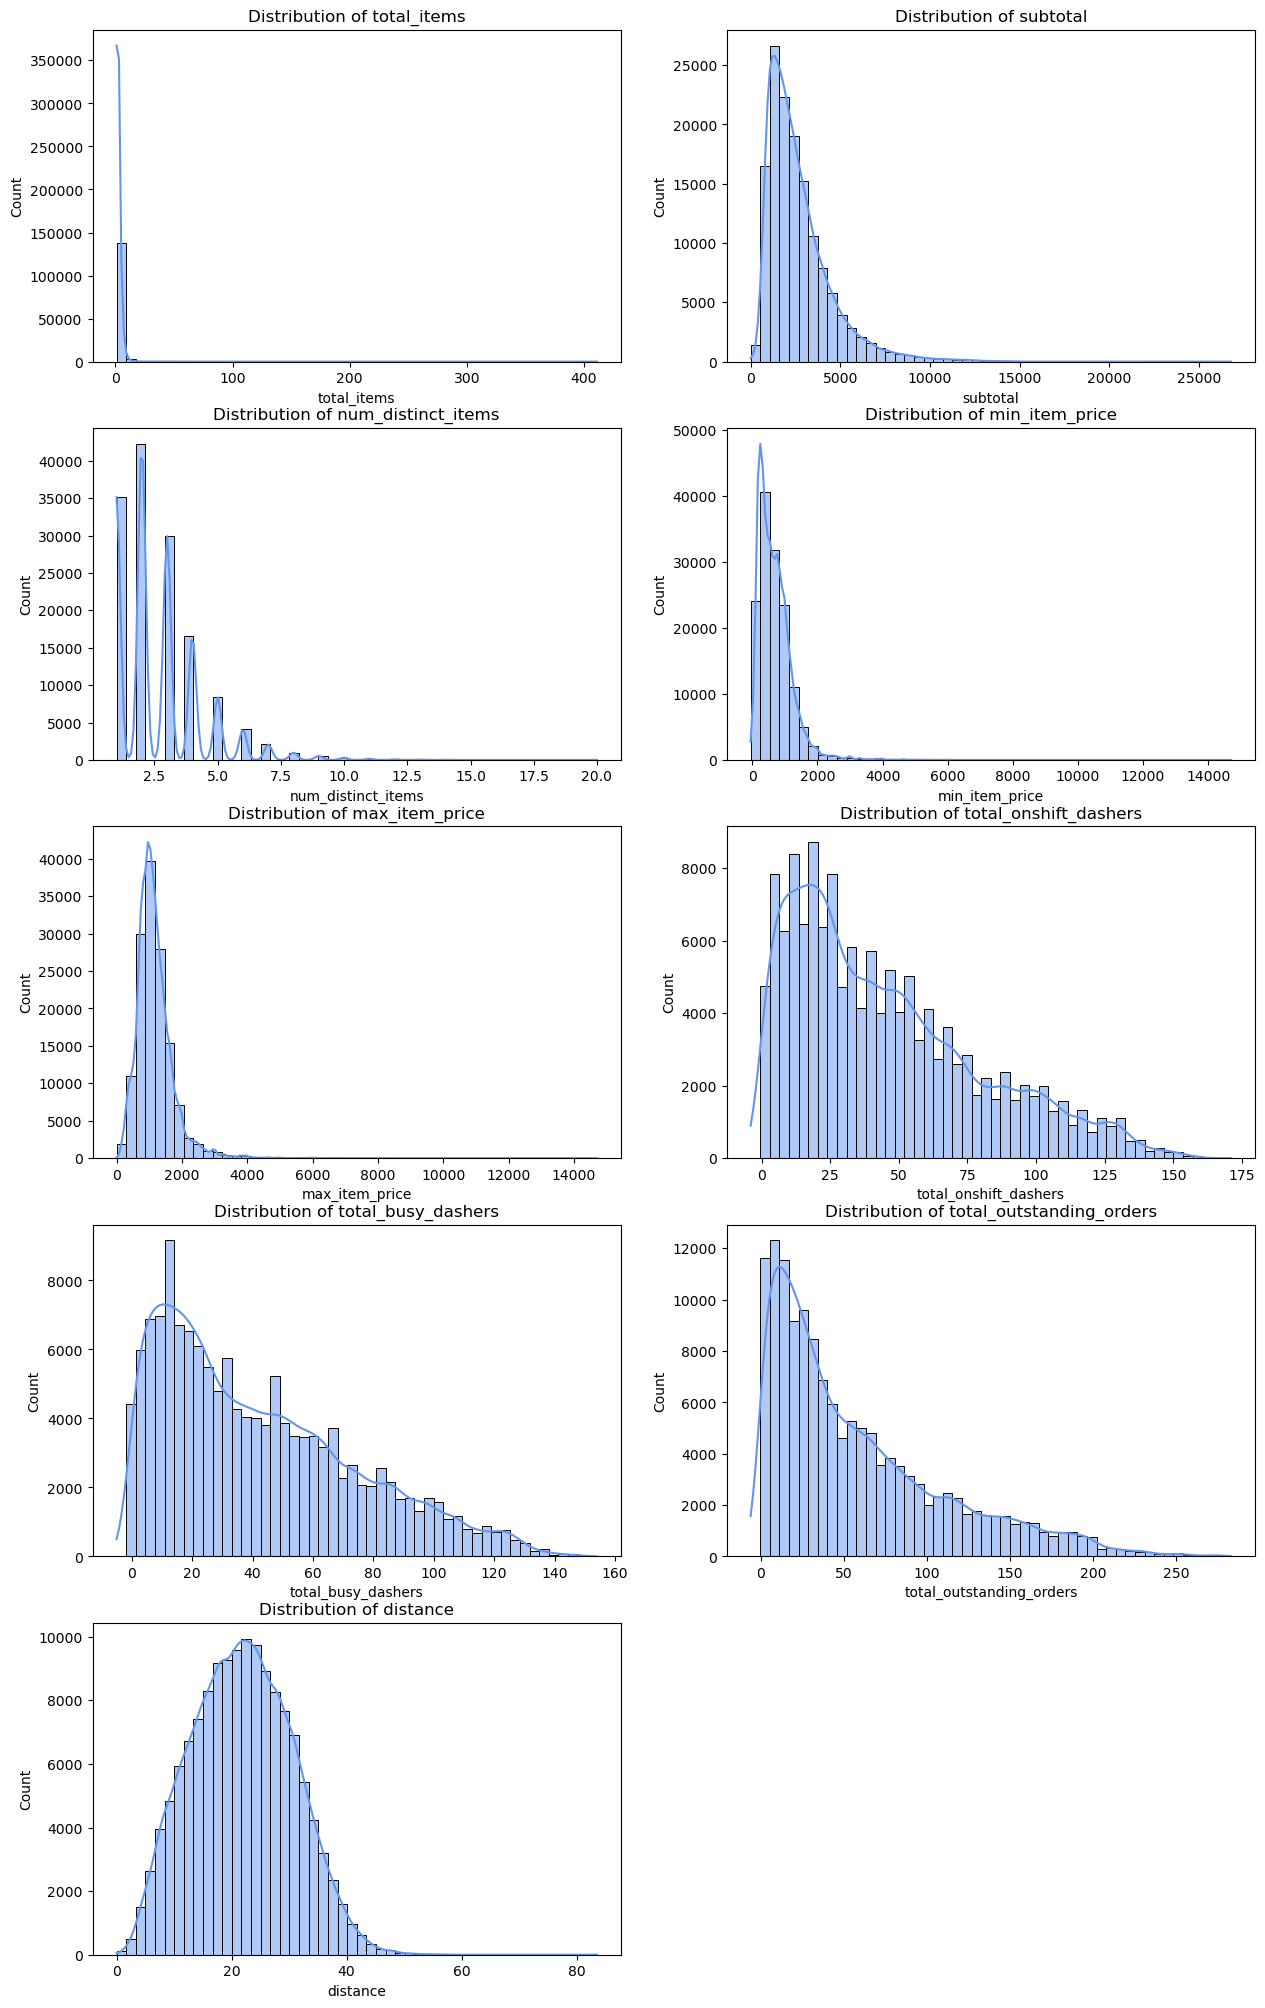

In [355]:
# Plot distributions for all numerical columns

n_cols = 2
n_rows = (len(numerical_cols) + 1) // n_cols
plt.figure(figsize=(15, 5 * n_rows))

# Plotting distribution of each column in the training set
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(x_train[col], bins=50, kde=True, color='cornflowerblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

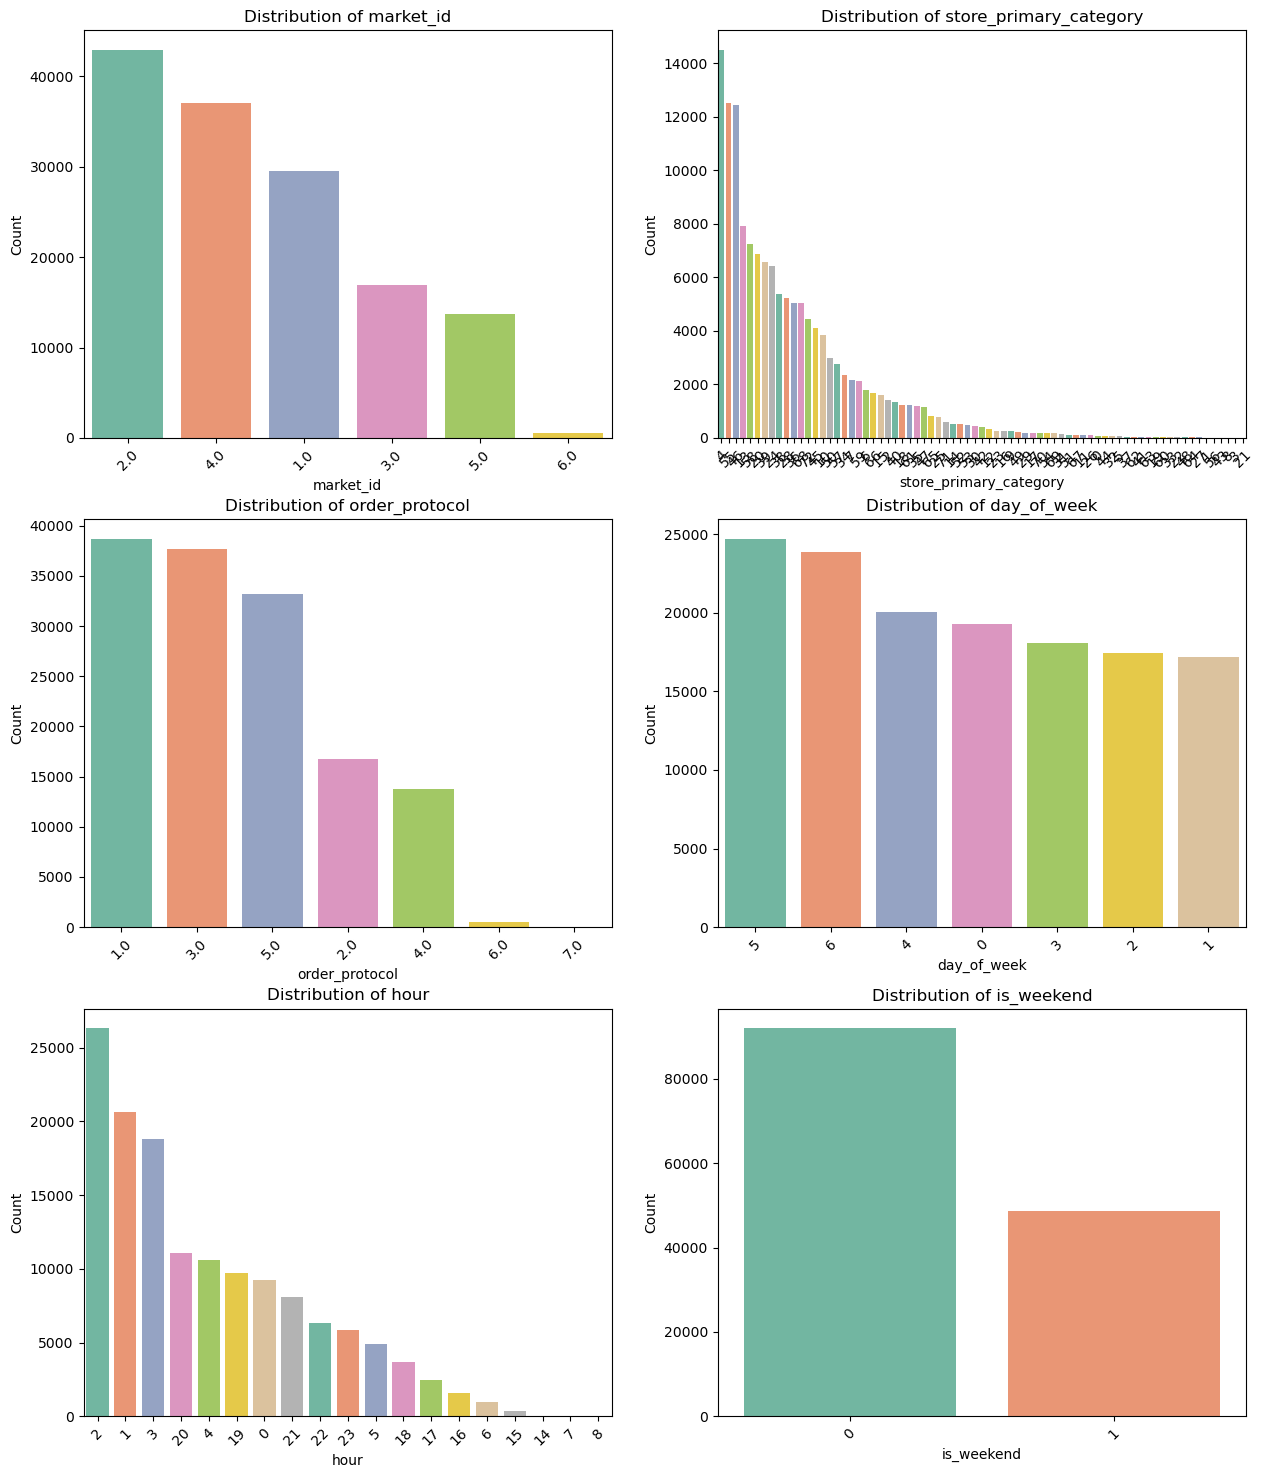

In [356]:
# Distribution of categorical columns

n_cols = 2
n_rows = (len(categorical_features) + 1) // n_cols
plt.figure(figsize=(15, 6 * n_rows))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(n_rows, n_cols, i)
    #sns.histplot(x_train[col], bins=50, kde=True, color='cornflowerblue')
    sns.countplot(data=x_train, x=col, order=x_train[col].value_counts().index, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

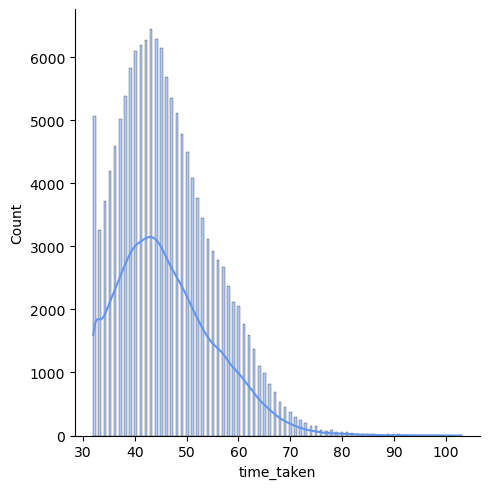

In [357]:
# Distribution of time_taken

sns.displot(y_train, kde = True, color='cornflowerblue')
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

In [358]:
x_train.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'day_of_week', 'hour',
       'is_weekend'],
      dtype='object')

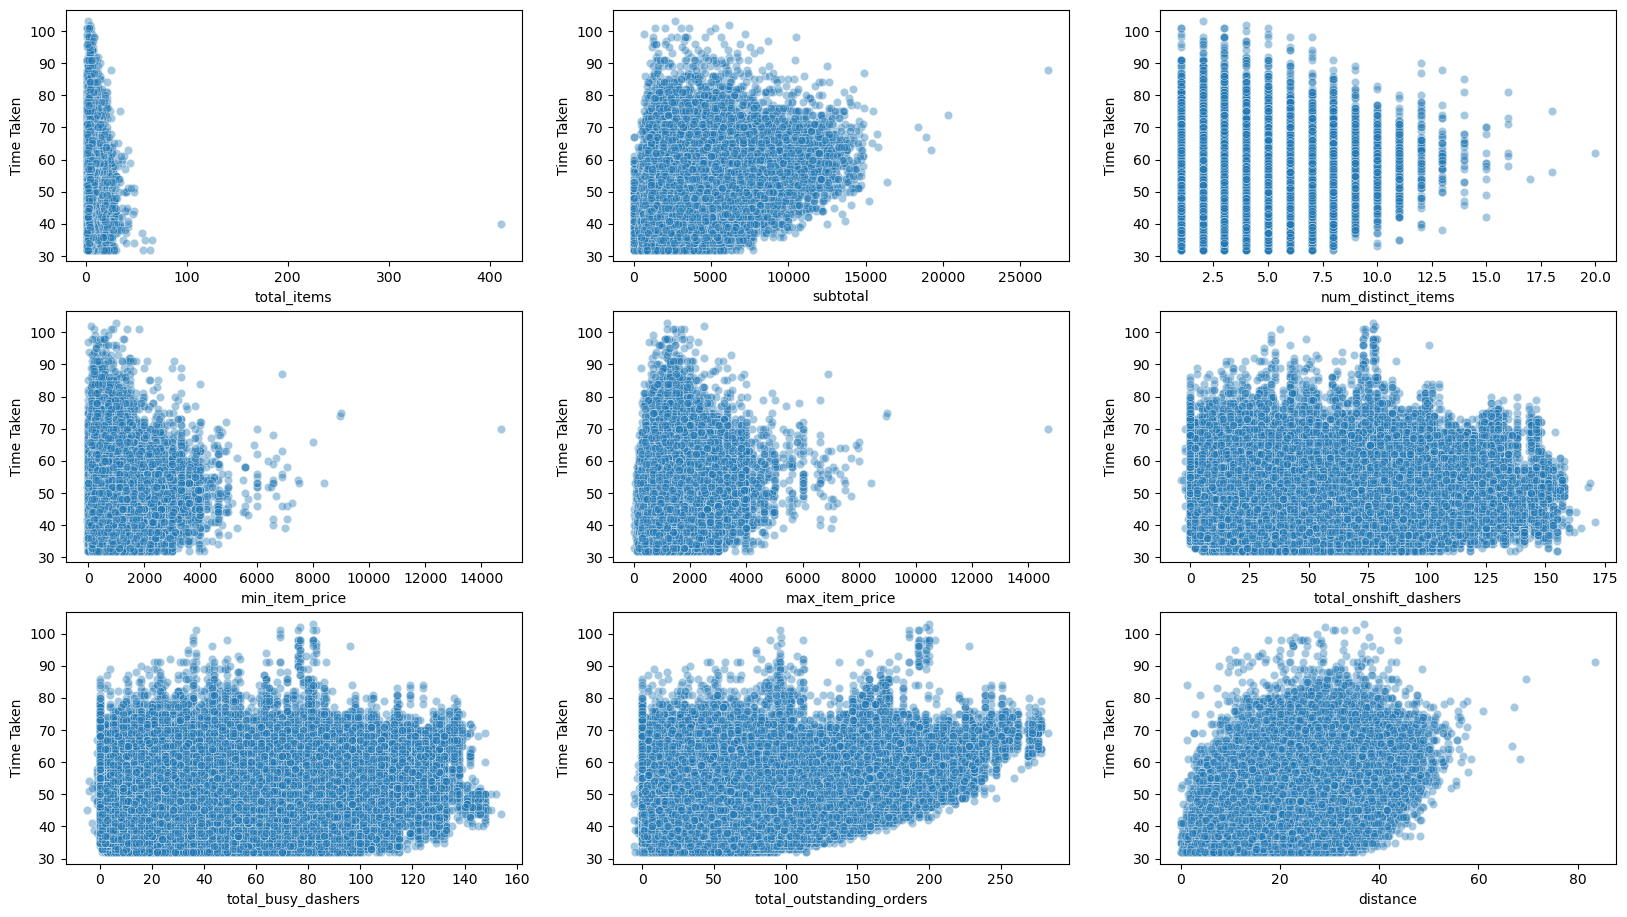

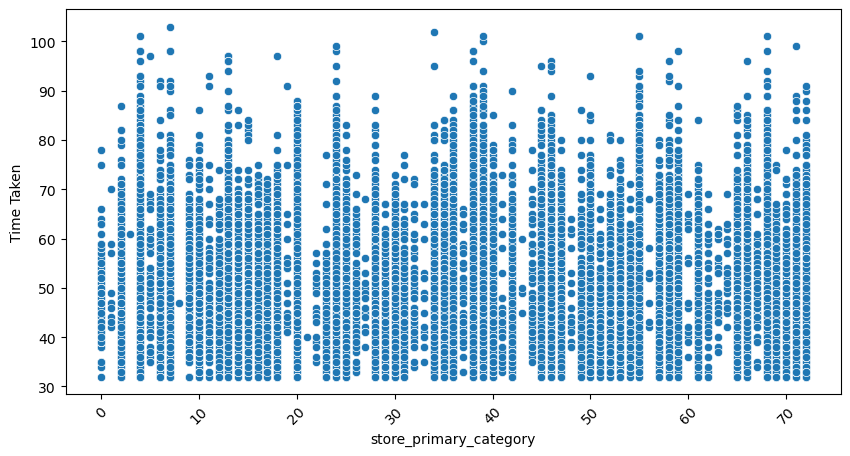

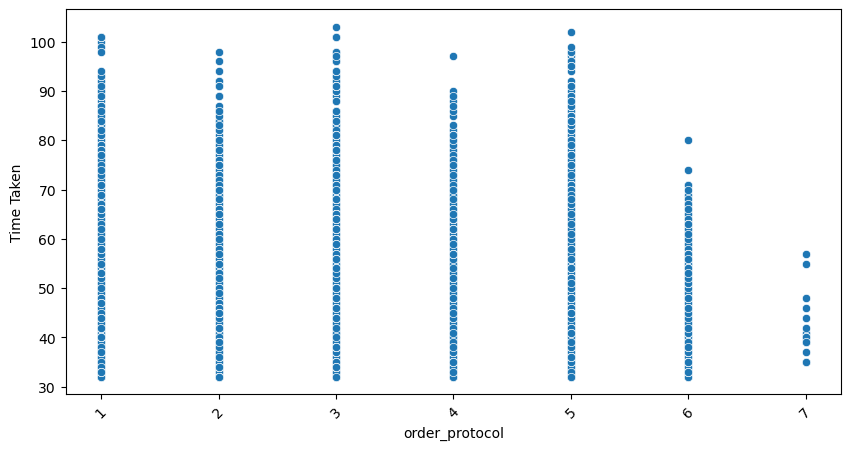

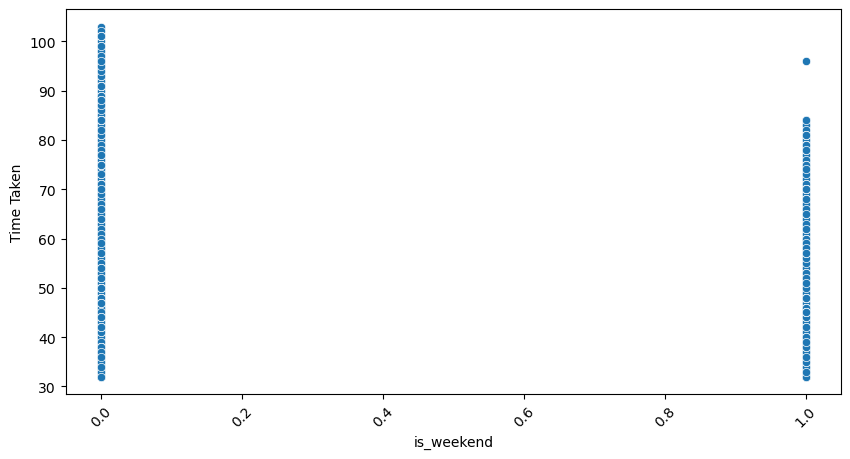

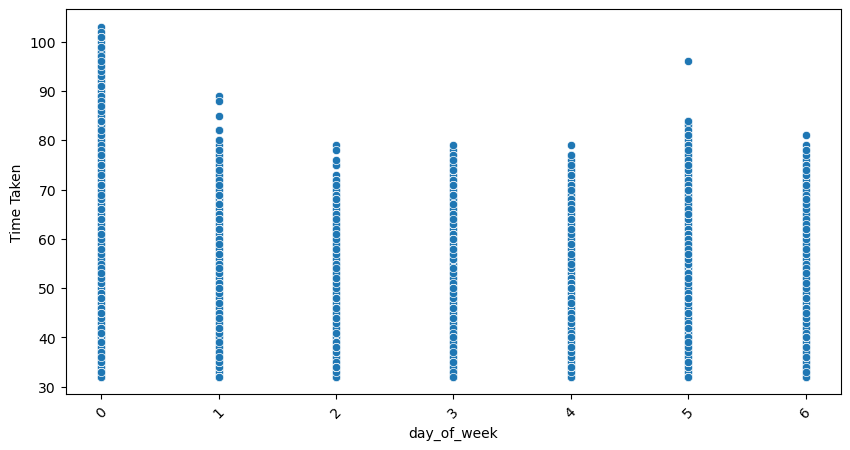

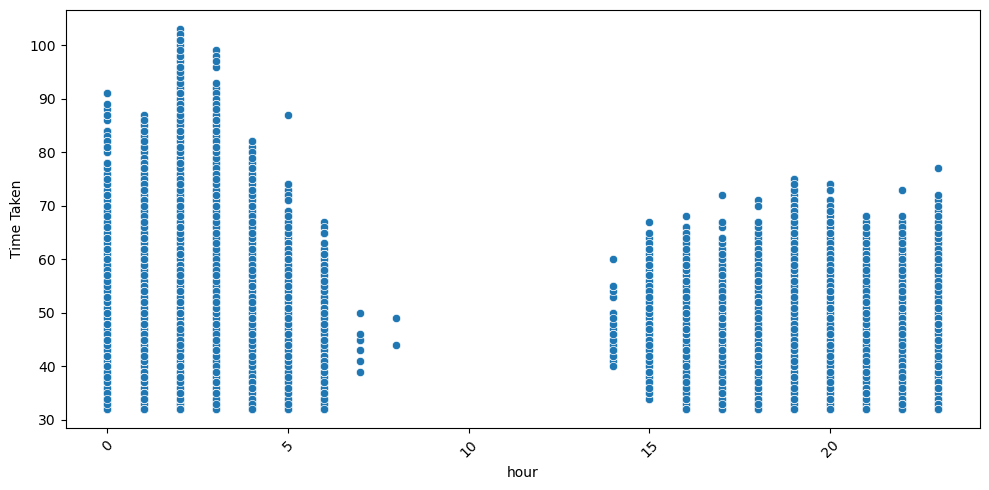

In [359]:
# Scatter plot to visualise the relationship between time_taken and other features


important_categorical = ['store_primary_category', 'order_protocol','is_weekend','day_of_week','hour']

# Plot numerical features vs delivery time using scatterplot
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(data=x_train, x=feature, y=y_train, alpha=0.4)
    plt.xlabel(feature)
    plt.ylabel('Time Taken')

# Plot categorical features vs delivery time using scatterplot
for i, feature in enumerate(important_categorical, 1):
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=x_train, x=feature, y=y_train, palette='Set3')
    plt.xlabel(feature)
    plt.ylabel('Time Taken')
    plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

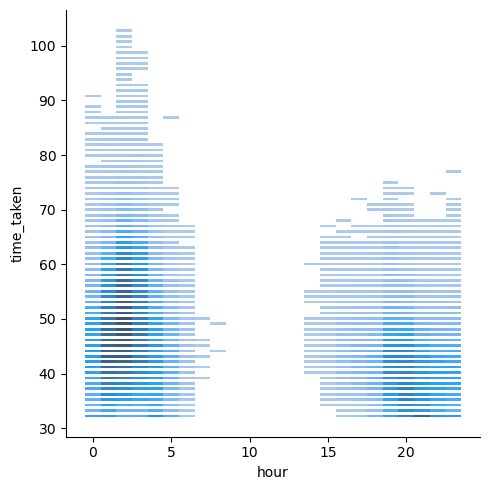

In [360]:
# Show the distribution of time_taken for different hours

sns.displot(data = x_train, x = 'hour', y= y_train)
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

<Axes: >

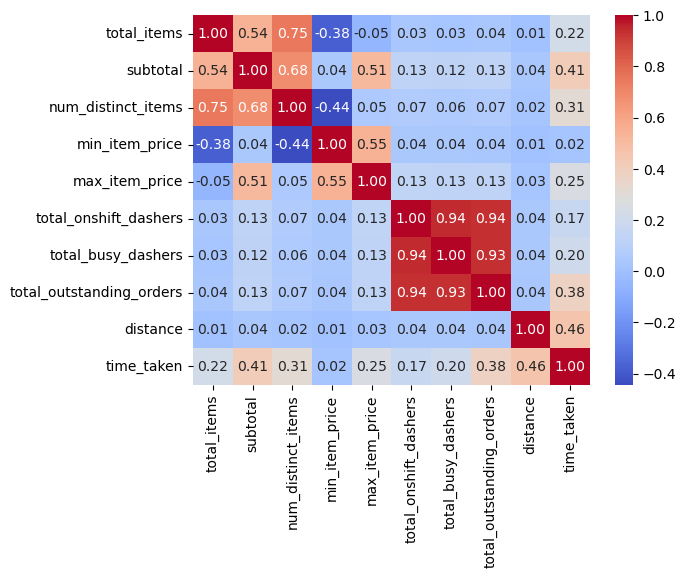

In [361]:
# Plot the heatmap of the correlation matrix
x_train_t = x_train[numerical_cols]
x_train_t['time_taken'] = y_train
sns.heatmap(x_train_t.corr(), annot=True, cmap='coolwarm', fmt='.2f')

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [362]:
# Drop 3-5 weakly correlated columns from training dataset


# Dropping columns with weak correlation to the target variable
# The columns 'min_item_price', 'total_onshift_dashers', 'total_items', and 'max_item_price' are weakly correlated with the target variable
# 'num_distinct_items' is highly correlated with subtotal hence can be dropped as well
x_train_t.drop(columns = ['min_item_price','total_onshift_dashers','total_items','max_item_price','num_distinct_items'], inplace = True)
x_train.drop(columns = ['min_item_price','total_onshift_dashers','total_items','max_item_price','num_distinct_items'], inplace = True)

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

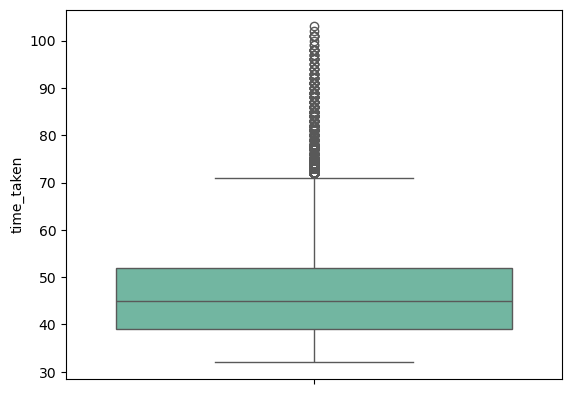

In [363]:
# Boxplot for time_taken

sns.boxplot( data = x_train, y = y_train, palette='Set2')
plt.show()


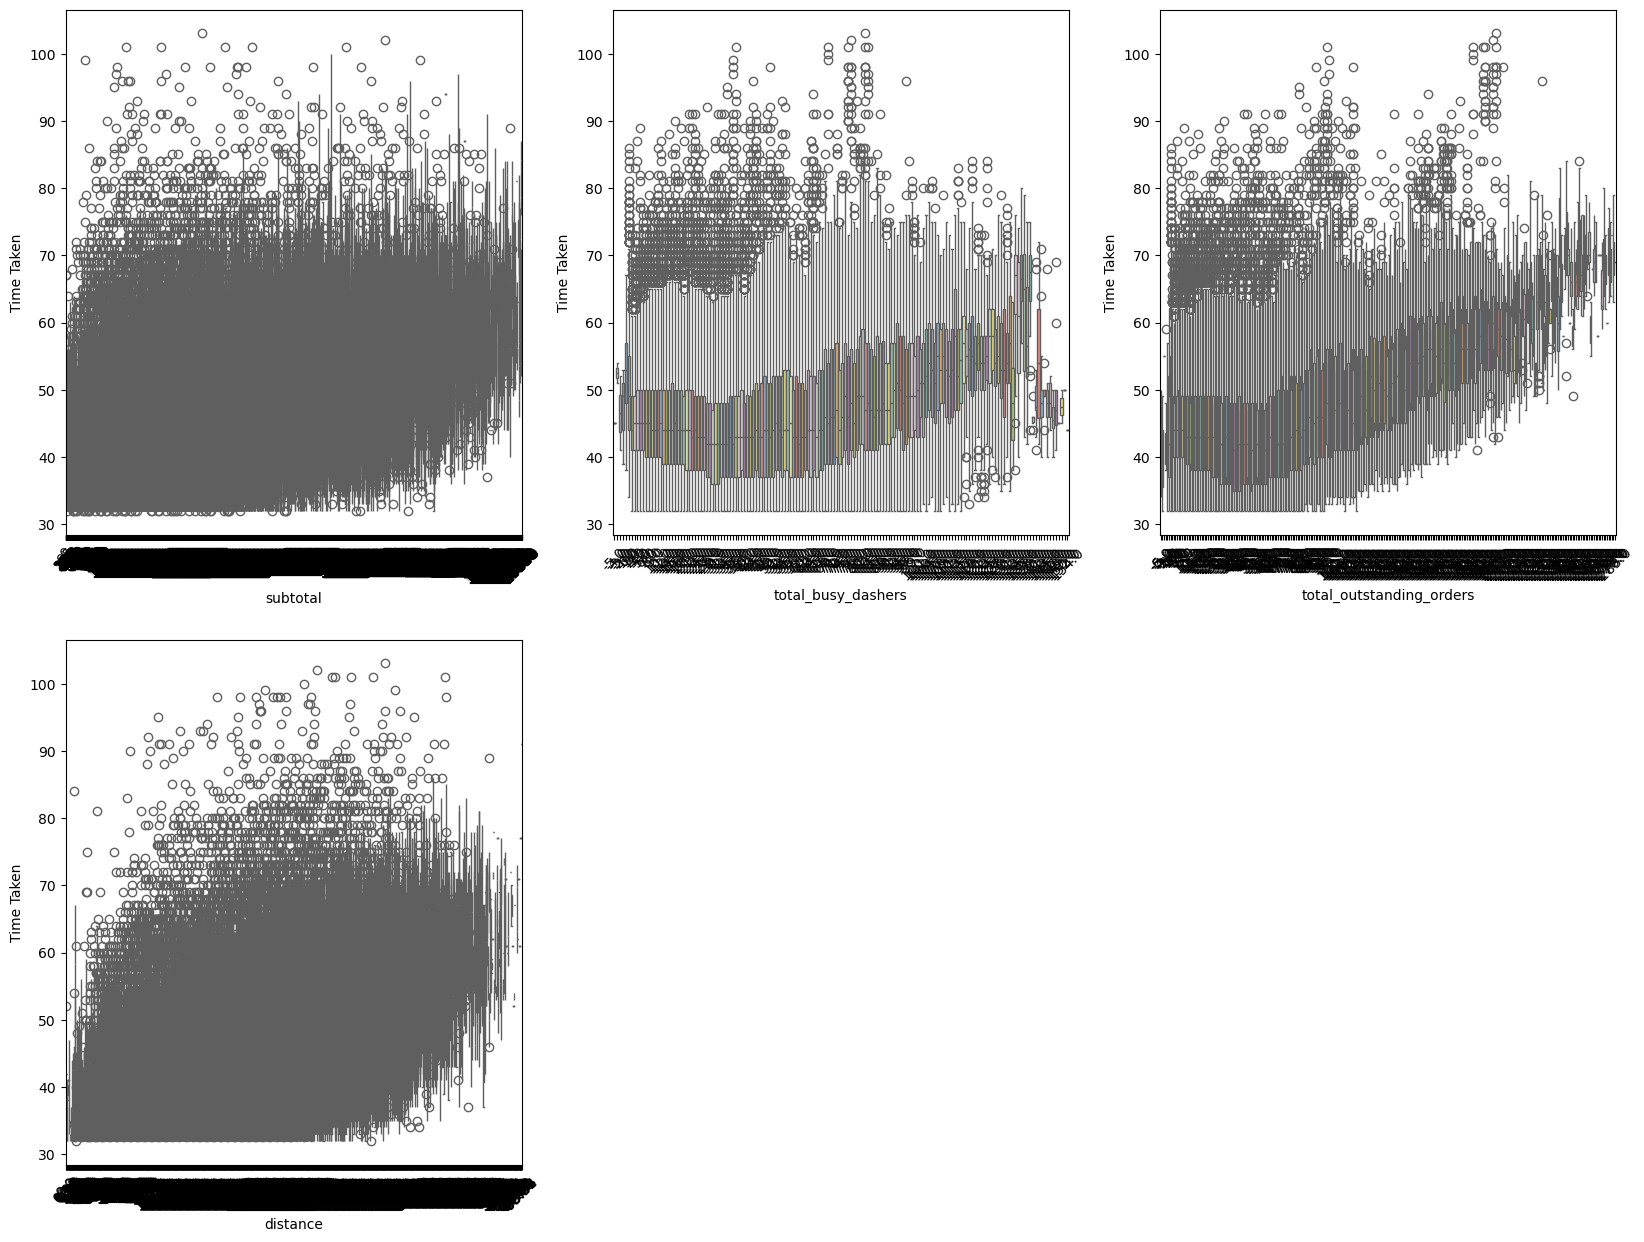

In [364]:
# Plot categorical features vs delivery time using scatterplot

numerical_cols = x_train.select_dtypes(include = ['int64','float64']).columns.tolist()
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_cols, 1):
    plt.subplot(2,3,i)
    sns.boxplot(data=x_train, x=feature, y=y_train, palette='Set3')
    plt.xlabel(feature)
    plt.ylabel('Time Taken')
    plt.xticks(rotation=45)



##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [365]:
# Handle outliers

x_train.info(())

x_train_combine = pd.concat([x_train, y_train], axis = 1)
x_train_combine.head()


<class 'pandas.core.frame.DataFrame'>
Index: 140621 entries, 42111 to 38408
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   market_id                 140621 non-null  category
 1   store_primary_category    140621 non-null  category
 2   order_protocol            140621 non-null  category
 3   subtotal                  140621 non-null  int64   
 4   total_busy_dashers        140621 non-null  float64 
 5   total_outstanding_orders  140621 non-null  float64 
 6   distance                  140621 non-null  float64 
 7   day_of_week               140621 non-null  category
 8   hour                      140621 non-null  category
 9   is_weekend                140621 non-null  category
dtypes: category(6), float64(3), int64(1)
memory usage: 10.2 MB


market_id store_primary_category order_protocol  subtotal  \
42111        3.0                      7            2.0      1350   
58452        2.0                     46            5.0      4285   
20644        4.0                     45            2.0      7880   
79735        4.0                     45            2.0      3660   
167933       1.0                      4            5.0      8575   

        total_busy_dashers  total_outstanding_orders  distance day_of_week  \
42111                 20.0                      19.0      9.60           0   
58452                100.0                     207.0     34.56           5   
20644                 79.0                     115.0     34.92           4   
79735                106.0                     173.0     25.76           5   
167933                44.0                      61.0     17.72           3   

       hour is_weekend  time_taken  
42111    20          0        32.0  
58452     2          1        71.0  
20644     3          0        62.0  
79735     2          1        54.0  
167933    2          0        56.0

In [366]:
#filtering outliers based on time_taken >80


x_train_combine = x_train_combine[x_train_combine['time_taken'] < 80]
x_train_combine.shape, x_train.shape




((140231, 11), (140621, 10))

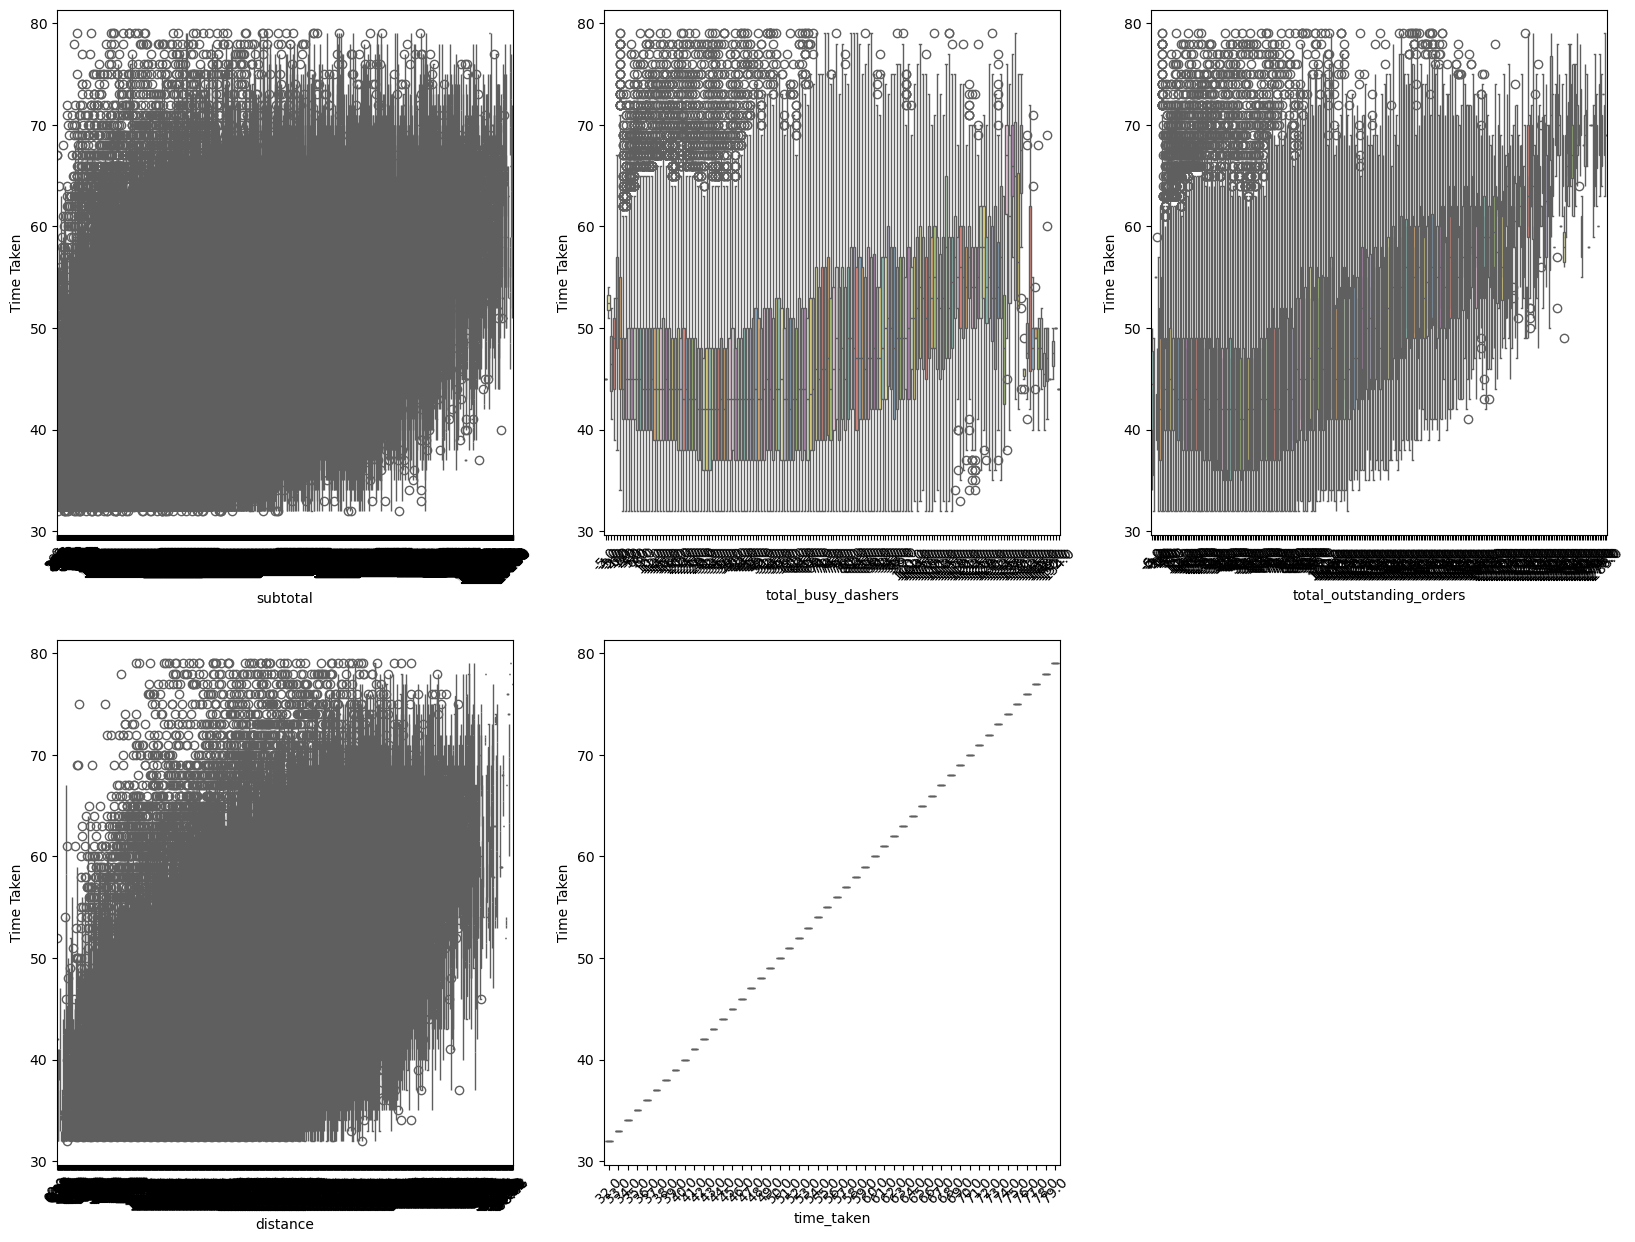

In [367]:
# we will recheck the distribution of time_taken after removing outliers

numerical_cols = x_train_combine.select_dtypes(include = ['int64','float64']).columns.tolist()
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_cols, 1):
    plt.subplot(2,3,i)
    sns.boxplot(data=x_train_combine, x=feature, y='time_taken', palette='Set3')
    plt.xlabel(feature)
    plt.ylabel('Time Taken')
    plt.xticks(rotation=45)

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [ ]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [ ]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [ ]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [405]:
# Import libraries

import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [369]:
x_train_combine['time_taken'] = x_train_combine['time_taken'].astype('float64')

In [370]:
numeric = x_train_combine.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric

['subtotal',
 'total_busy_dashers',
 'total_outstanding_orders',
 'distance',
 'time_taken']

In [ ]:
# Apply scaling to the numerical columns


scaler = MinMaxScaler()
x_train_combine[numeric] = scaler.fit_transform(x_train_combine[numeric])
x_train_combine.nunique()


market_id                      6
store_primary_category        73
order_protocol                 7
subtotal                    7735
total_busy_dashers           158
total_outstanding_orders     280
distance                    1300
day_of_week                    7
hour                          19
is_weekend                     2
time_taken                    48
dtype: int64

In [372]:
x_train.shape, x_test.shape


((140621, 10), (35156, 15))

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [373]:
#dropping columns from test dataset as well to match the column count with train dataset
x_test.drop(columns = ['min_item_price','total_onshift_dashers','total_items','max_item_price','num_distinct_items'], inplace = True)

In [374]:
# Reassigning the target variable to a list
y_train_sm = x_train_combine['time_taken'].values.tolist()
x_train_sm = x_train_combine.drop(columns = ['time_taken'])

In [ ]:
# Create/Initialise the model

x_train_sm = sm.add_constant(x_train_sm)


In [377]:
# Train the model using the training data
lr_model = sm.OLS(y_train_sm, x_train_sm).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                 3.893e+04
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        00:24:06   Log-Likelihood:             1.2442e+05
No. Observations:              140231   AIC:                        -2.488e+05
Df Residuals:                  140220   BIC:                        -2.487e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1363      0.001    100.713      0.000       0.134       0.139
market_id                   -0.0144      0.000    -71.412      0.000      -0.015      -0.014
store_primary_category    8.032e-05   1.29e-05      6.210      0.000     5.5e-05       0.000
order_protocol              -0.0161      0.000    -89.924      0.000      -0.016      -0.016
subtotal                     0.6962      0.003    228.791      0.000       0.690       0.702
total_busy_dashers          -1.1563      0.004   -312.834      0.000      -1.164      -1.149
total_outstanding_orders     1.4826      0.004    359.414      0.000       1.475       1.491
distance                     0.6819      0.002    326.851      0.000       0.678       0.686
day_of_week                 -0.0137      0.000    -61.835      0.000      -0.014      -0.013
hour                        -0.0043   3.34e-05   -127.594      0.000      -0.004      -0.004
is_weekend                   0.0854      0.001     89.854      0.000       0.083       0.087
==============================================================================
Omnibus:                     5432.915   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13227.668
Skew:                           0.212   Prob(JB):                         0.00
Kurtosis:                       4.443   Cond. No.                         865.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [378]:
x_train.shape, x_test.shape

((140621, 10), (35156, 10))

In [379]:
y_test

139667    39.0
80077     42.0
41872     48.0
165269    55.0
151215    37.0
          ... 
112022    49.0
84475     44.0
119329    33.0
3479      42.0
98870     40.0
Name: time_taken, Length: 35156, dtype: float64

In [380]:
# Applying Scaler on testig data

x_test_combine = pd.concat((x_test, y_test), axis = 1)
numeric = x_test_combine.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric


['subtotal',
 'total_busy_dashers',
 'total_outstanding_orders',
 'distance',
 'time_taken']

In [381]:


x_test_combine[numeric] = scaler.transform(x_test_combine[numeric])


In [382]:
# Make predictions

y_test_scaled = x_test_combine['time_taken'].values.tolist()
x_test_sm = x_test_combine.drop(columns = ['time_taken'])



In [384]:
#x_test_sm = x_test[['subtotal','total_outstanding_orders','distance','is_weekend']]

x_test_sm = sm.add_constant(x_test_sm)

y_test_pred = lr_model.predict(x_test_sm)

In [398]:
# Find results for evaluation metrics

# calculating residuals, mean_squared error, root mean squared error and r2 score
resd = y_test_pred - y_test_scaled

mse = mean_squared_error(y_test_scaled, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, y_test_pred)

print( "\nMean Squared Error : " + str(mse)  + "\nRoot mean Squared Error: " + str(rmse) + "\nR2 Score: " + str(r2))


Mean Squared Error : 0.01049869949230566
Root mean Squared Error: 0.10246316163531974
R2 Score: 0.7342678375846625


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [421]:
# Loop through the number of features and test the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rfe_results = []

X_scaled = scaler.fit_transform(X)
lr = LinearRegression()
for n in range(1, X.shape[1]+1, 1):  

    selector = RFE(lr, n_features_to_select=n)
    X_rfe = selector.fit_transform(X_scaled, y)

    X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    rfe_results.append((n, mse, r2))

# Convert results to DataFrame
rfe_df = pd.DataFrame(rfe_results, columns=['Num_Features', 'MSE', 'R2'])
print(rfe_df)


    Num_Features        MSE        R2
0              1  74.562366  0.148124
1              2  48.767940  0.442826
2              3  36.228520  0.586089
3              4  18.977077  0.783187
4              5  16.900126  0.806916
5              6  16.897353  0.806948
6              7  16.722887  0.808941
7              8  16.414816  0.812461
8              9  12.399539  0.858335
9             10  11.456466  0.869110
10            11  11.444613  0.869245
11            12  10.758577  0.877083
12            13  10.423639  0.880910
13            14  10.403922  0.881135
14            15  10.392724  0.881263


In [424]:
# Build the final model with selected number of features

# as RFE shows that R2 score and MSE becomes quite stable after the 12the feature, so it was good to go with 12 features.
# but as per our previous analysis we have already dropped 5 features which were weakly correlated with the target variable.
# So we will build the final model with 10 features which are highly correlated with the target variable and also not having multicollinearity issues.
# which is exactly the mdodel which we have already built above.

lr_model = sm.OLS(y_train_sm, x_train_sm).fit()
lr_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                 3.893e+04
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        09:31:11   Log-Likelihood:             1.2442e+05
No. Observations:              140231   AIC:                        -2.488e+05
Df Residuals:                  140220   BIC:                        -2.487e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1363      0.001    100.713      0.000       0.134       0.139
market_id                   -0.0144      0.000    -71.412      0.000      -0.015      -0.014
store_primary_category    8.032e-05   1.29e-05      6.210      0.000     5.5e-05       0.000
order_protocol              -0.0161      0.000    -89.924      0.000      -0.016      -0.016
subtotal                     0.6962      0.003    228.791      0.000       0.690       0.702
total_busy_dashers          -1.1563      0.004   -312.834      0.000      -1.164      -1.149
total_outstanding_orders     1.4826      0.004    359.414      0.000       1.475       1.491
distance                     0.6819      0.002    326.851      0.000       0.678       0.686
day_of_week                 -0.0137      0.000    -61.835      0.000      -0.014      -0.013
hour                        -0.0043   3.34e-05   -127.594      0.000      -0.004      -0.004
is_weekend                   0.0854      0.001     89.854      0.000       0.083       0.087
==============================================================================
Omnibus:                     5432.915   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13227.668
Skew:                           0.212   Prob(JB):                         0.00
Kurtosis:                       4.443   Cond. No.                         865.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [425]:
y_test_pred = lr_model.predict(x_test_sm)

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

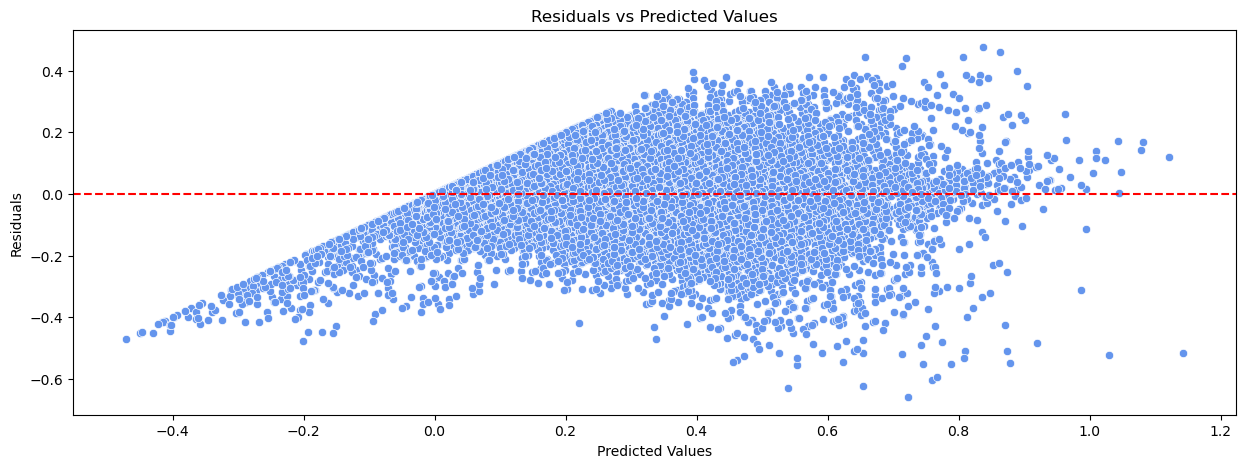

In [431]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
resd = y_test_pred - y_test_scaled
plt.figure(figsize=(15, 5))
sns.scatterplot(x=y_test_pred, y=resd, color='cornflowerblue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


Text(0.5, 1.0, 'Q-Q Plot')

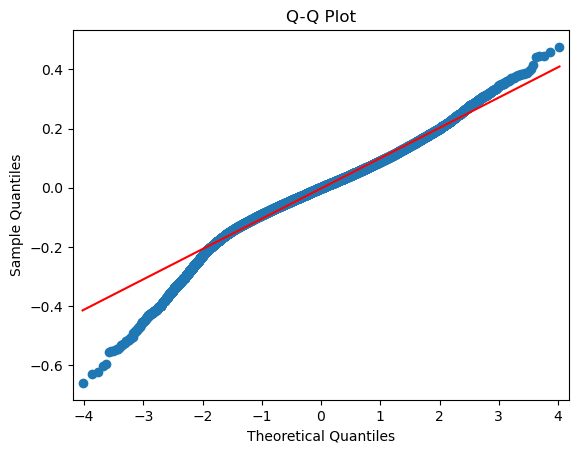

In [433]:
#Q-Q plot
sm.qqplot(resd, line='s')
plt.title('Q-Q Plot')

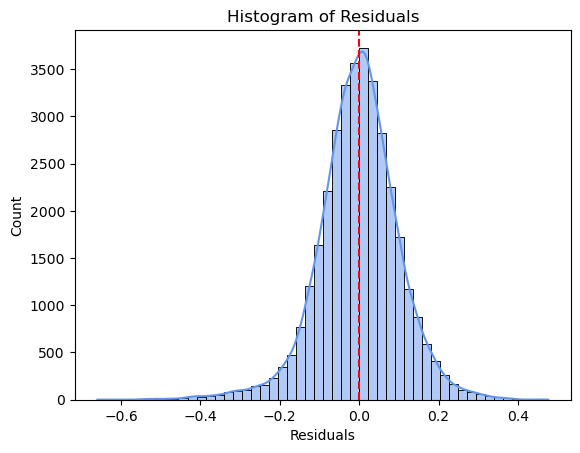

In [436]:
# Histogram of residuals
sns.histplot(resd, bins=50, kde=True, color='cornflowerblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Histogram of Residuals')
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [488]:
# Compare the scaled vs unscaled features used in the final model

x_unscaled = pd.concat((x_train, y_train), axis = 1)

x_unscaled = x_unscaled.dropna(subset = ['market_id', 'store_primary_category', 'order_protocol', 'subtotal',
       'total_busy_dashers', 'total_outstanding_orders', 'distance',
       'day_of_week', 'hour', 'is_weekend', 'time_taken'])

x_unscaled = x_unscaled[x_unscaled['time_taken'] < 80]
y_unscaled = x_unscaled['time_taken'].values.tolist()
x_unscaled = x_unscaled.drop(columns = ['time_taken'])
x_unscaled = sm.add_constant(x_unscaled)



In [489]:
lr_model_unscaled = sm.OLS(y_unscaled, x_unscaled).fit()
lr_model_unscaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                 3.119e+04
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        10:46:12   Log-Likelihood:            -3.3226e+05
No. Observations:              112164   AIC:                         6.645e+05
Df Residuals:                  112153   BIC:                         6.646e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       38.1792      0.071    541.300      0.000      38.041      38.317
market_id                   -0.6751      0.011    -63.941      0.000      -0.696      -0.654
store_primary_category       0.0039      0.001      5.733      0.000       0.003       0.005
order_protocol              -0.7659      0.009    -81.208      0.000      -0.784      -0.747
subtotal                     0.0016   7.84e-06    204.278      0.000       0.002       0.002
total_busy_dashers          -0.3409      0.001   -279.529      0.000      -0.343      -0.339
total_outstanding_orders     0.2405      0.001    321.398      0.000       0.239       0.242
distance                     0.4683      0.002    292.683      0.000       0.465       0.471
day_of_week                 -0.6475      0.012    -55.720      0.000      -0.670      -0.625
hour                        -0.1995      0.002   -113.788      0.000      -0.203      -0.196
is_weekend                   4.0301      0.050     80.700      0.000       3.932       4.128
==============================================================================
Omnibus:                     4287.324   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10472.864
Skew:                           0.206   Prob(JB):                         0.00
Kurtosis:                       4.439   Cond. No.                     1.68e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [493]:
lr_scaled = lr_model
lr_unscaled = lr_model_unscaled

coeff_comparison = pd.DataFrame({
    'Feature': x_unscaled.columns,
    'Coefficient_Unscaled': lr_unscaled.params.values,
    'Coefficient_Scaled': lr_scaled.params.values
})

coeff_comparison = coeff_comparison.set_index('Feature')
coeff_comparison = coeff_comparison.drop('const')
coeff_comparison = coeff_comparison.reset_index()
coeff_comparison['Difference'] = coeff_comparison['Coefficient_Scaled'] - coeff_comparison['Coefficient_Unscaled']

coeff_comparison


Feature  Coefficient_Unscaled  Coefficient_Scaled  \
0                 market_id             -0.675065           -0.014354   
1    store_primary_category              0.003897            0.000080   
2            order_protocol             -0.765938           -0.016140   
3                  subtotal              0.001602            0.696163   
4        total_busy_dashers             -0.340932           -1.156289   
5  total_outstanding_orders              0.240526            1.482638   
6                  distance              0.468269            0.681896   
7               day_of_week             -0.647532           -0.013674   
8                      hour             -0.199517           -0.004263   
9                is_weekend              4.030077            0.085358   

   Difference  
0    0.660711  
1   -0.003817  
2    0.749798  
3    0.694562  
4   -0.815357  
5    1.242112  
6    0.213626  
7    0.633858  
8    0.195254  
9   -3.944719

In [495]:
# Analyze the effect of a unit change in a feature, say 'total_items'

# 1- the effect of change in subtotal is the highest on the target variable in scaled model, whetheher in unscaled it is the lowest which actually makes sense because it is a currency value. 
# but model makes it significant after scaling
# 2- the effect of change in distance feature is also higher in both models which makes it significant in the model.
# 3- total_outstanding_orders is having big difference after scalling which makes it clear that it will have huge impact if this variable changes.

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>

below categorical variables are having higher impact on delivery time-
 1- order_protocol
 2- is_weekends

Weekend variable has higher coefficient which means it has makes big impact on delivery time if it is a weekend
change in order protocol will also impact the delivery time.

---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>

test_siize = 0.2 means the data will be splitted in ratio of 80:20 , 80 % data will be splitted in training set and 20 % data will be splitted into test set



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>

#### Distance
has the highest correlation with the target variable



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>

I plotted all the variables against the target variables, which showed that the mostly variables are having outlier as time_taken > 80 mins,
So I dropped those rows where delivery time was more than 80 mins



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>

##### Based on the final model, below are the variables which are affeting the delivery time most

    1- Distance
    2- Weekend
    3- Total Outstanding orders

---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>


Linear Regression is a supervised machine learning algorithm used to predict a continuous target variable based on one or more input features. It finds the best-fitting straight line in (2D) or hyperplane (in higher dimensions) by minimizing the sum of squared differences between actual and predicted values. 

Equation : y = B0 + B1X1 + B2X2....BnXn

where-

    y is the predictor output
    B0 is the intercept
    Bi is teh model coefficient
    Xi are the input features






---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>

Simple linear regression work on only 1 independent variable whereas multiple linear regression comes into picture where we have many independent varables which are impacting the target variable.


---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>


The cost function in linear regression measures how well the model’s predictions match the actual data. It is typically the Mean Squared Error (MSE), which calculates the average of the squares of prediction errors.
The goal of linear regression is to minimize this cost function, so the line fits the data as accurately as possible.



---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>

Overfitting happens when a model learns the training data too well, including noise and outliers. It performs well on training data but poorly on unseen data (low bias, high variance).

Underfitting occurs when a model is too simple to capture the underlying patterns in the data. It performs poorly on both training and test data (high bias, low variance).



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>

Residual plots show the difference between actual and predicted values (residuals) plotted against the predicted values or input features. They help in:

<b>Checking Linearity:</b> If residuals are randomly scattered around zero, the linear model is appropriate. Patterns suggest non-linearity.

<b>Detecting Homoscedasticity:</b> Equal spread of residuals indicates constant variance. Funnel shapes suggest heteroscedasticity, which violates linear regression assumptions.

<b>Identifying Outliers:</b> Large residuals in the plot can point to outliers that may affect model performance.

A good linear regression model should have a residual plot with no clear pattern and evenly spread residuals around zero.